In [3]:
import torch
import torch.nn as nn

# Discriminator

In [4]:
class Discriminator(nn.Module):

  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # input: N * channels_img* 64*64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        # N*feature_dim, 32*32
        self._block(features_d,features_d*2, 4 , 2 , 1), # N*feature_dim, 16*16
        self._block(features_d*2,features_d*4, 4 , 2 , 1), # N*feature_dim, 8*8
        self._block(features_d*4,features_d*8, 4 , 2 , 1), # N*feature_dim, 4*4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # N*feature_dim, 1*1
        nn.Sigmoid(),
    )



  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )



  def forward(self,x):
    return self.disc(x)

In [5]:
class Generator(nn.Module):

  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
            # input: N * z_dim * 1*1
            self._block(z_dim, features_g*16, 4, 1, 0), # N * f_g*16 * 4*4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8*8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16*16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32*32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # 64*64
            nn.Tanh(), # [-1,1]
    )

  def forward(self,x):
    return self.gen(x)


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [6]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100

  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1, 1)

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")


test()

Success


In [8]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
lr = 2e-4
batch_size = 128
img_size=64
channels_img = 1
z_dim = 100
num_epochs = 5
features_d = 64
features_g = 64

In [11]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]
    )
])

In [12]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 118611861.97it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102744439.21it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31149296.46it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16089973.62it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [13]:
gen = Generator(z_dim, channels_img,features_g).to(device)
disc = Discriminator(channels_img, features_d).to(device)

In [14]:
initialize_weights(gen)
initialize_weights(disc)

In [15]:
optim_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optim_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [16]:
fixed_noise = torch.randn(32,z_dim, 1, 1).to(device)

In [17]:
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [18]:
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [19]:
gen.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 1, 

In [20]:
import matplotlib.pyplot as plt

Epoch [0/5] Batch 0/469                 Loss D: 0.6518, Loss G: 0.8152


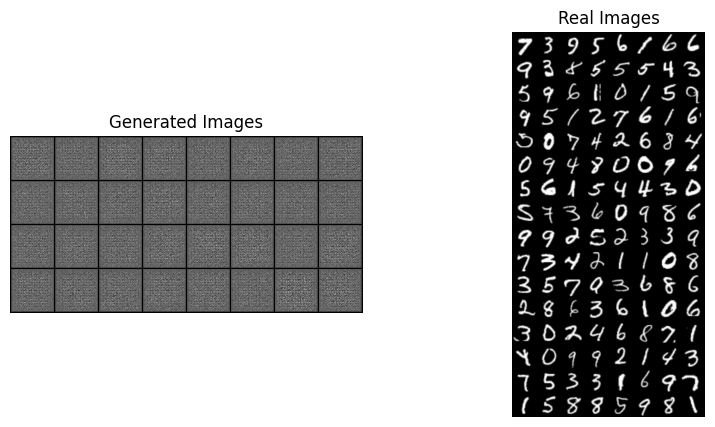

Epoch [1/5] Batch 0/469                 Loss D: 0.5308, Loss G: 0.7446


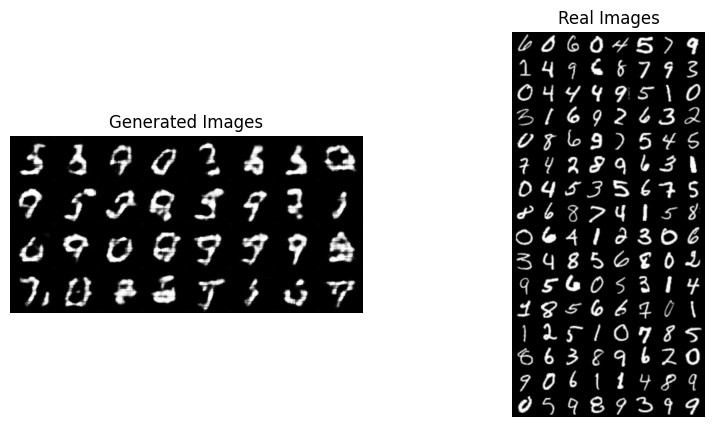

Epoch [2/5] Batch 0/469                 Loss D: 0.5751, Loss G: 0.9216


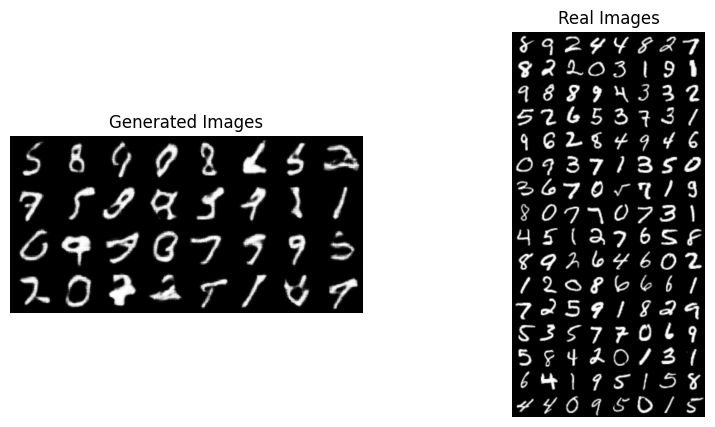

Epoch [3/5] Batch 0/469                 Loss D: 0.2248, Loss G: 3.3549


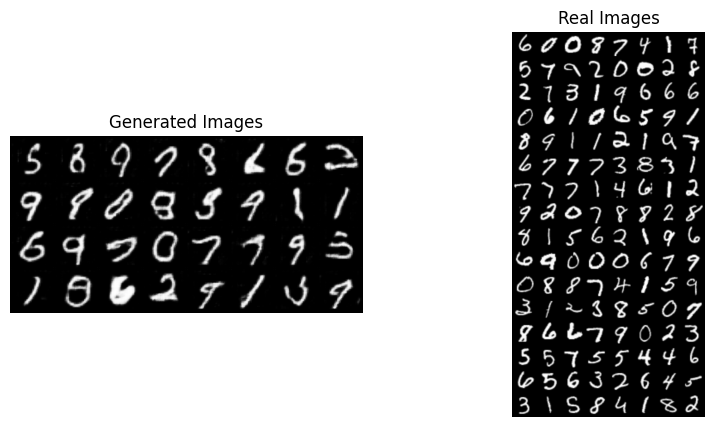

Epoch [4/5] Batch 0/469                 Loss D: 0.1872, Loss G: 4.1043


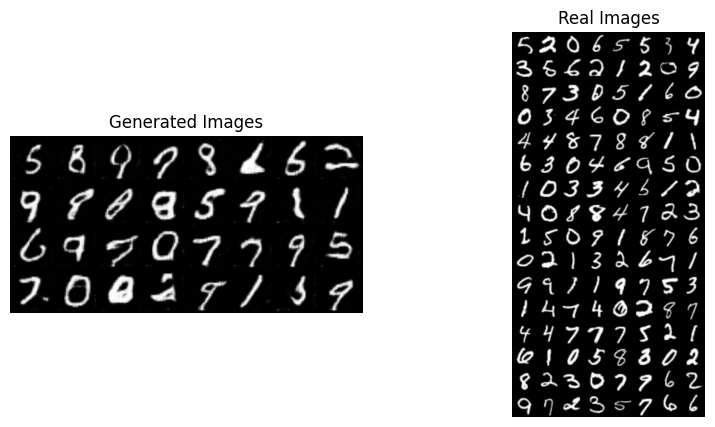

In [24]:
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)
    noise = torch.randn(batch_size, z_dim, 1, 1).to(device)

    # train discriminator
    fake = gen(noise)

    disc_real = disc(real).reshape(-1)
    lossD_real = criterion(disc_real,torch.ones_like(disc_real) )
    disc_fake = disc(fake).reshape(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake)/2

    disc.zero_grad()
    lossD.backward(retain_graph=True) # to not clear graph after backpropagation immediately, helps us to utilize fake (noise) again
    optim_disc.step()

    ## Train GENERATOR (min log(1-D(G(z))) <-> max log(D(G(z))) )
    output = disc(fake).reshape(-1)
    lossG = criterion(output,torch.ones_like(output) )
    gen.zero_grad()
    lossG.backward()
    optim_gen.step()


    # if batch_idx == 0:
    #         print(
    #             f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
    #                   Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
    #         )

    #         with torch.no_grad():
    #             fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
    #             data = real.reshape(-1, 1, 28, 28)
    #             img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
    #             img_grid_real = torchvision.utils.make_grid(data, normalize=True)

    #             writer_fake.add_image(
    #                 "Mnist Fake Images", img_grid_fake, global_step=step
    #             )
    #             writer_real.add_image(
    #                 "Mnist Real Images", img_grid_real, global_step=step
    #             )
    #             step += 1

    if batch_idx == 0:
       print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )
       fig, axes = plt.subplots(1, 2, figsize=(10, 5))

       with torch.no_grad():
          fake = gen(fixed_noise).reshape(-1, 1, 64, 64).cpu()  # Move to CPU
          data = real.reshape(-1, 1, 64, 64).cpu()  # Move to CPU

          # Visualize fake images
          img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
          axes[0].imshow(img_grid_fake.permute(1, 2, 0), cmap='gray')  # Adjust permute for channel order
          axes[0].set_title('Generated Images')
          axes[0].axis('off')

          # Visualize real images
          img_grid_real = torchvision.utils.make_grid(data, normalize=True)
          axes[1].imshow(img_grid_real.permute(1, 2, 0), cmap='gray')  # Adjust permute for channel order
          axes[1].set_title('Real Images')
          axes[1].axis('off')

          plt.show()